---
title: "Training an Emotional Face Classifier"
date: 2025-03-22
categories: [machine learning, tutorial, fastai, computer-vision]
slug: emotional-classifier
format:
  html:
    toc: true
    code-fold: true
---


![image](emotions.jpeg)

Ok I have been trying to get this thing posted for weeks and its finally time now. First step, what am I even doing. Well, broadly the goal is to get a decent understanding of deep learning concepts and apply them to subject matter I find interesting. I see this stage as learning to read sheet music and musc theory before I can create compositions. 

The first step is going to be training the model. It's taken me a while to decide what I want to train it on. Originally I wanted to do something music related, but now the desire to get something UP and POSTED has made me go with my first idea of emotion recognition in human faces.

# Begin Creating the Dataset

Before I get into any DL/ML specific things, I first have to import the fastai package into the notebook. So, that's what we see below:

In [2]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

Theoretially the pakage is set up. Now I need some data. Since this is my first post, I'm just going to use duckduckgo to grab some images from the internet. In practice, datasets must be curated more carefully than this. I'll use one trick I learned, but there are issues with going directly to image search. One of the biggest is that the data usually ends up being pretty biased. My guess is that if I do it this way I'll get an attractive white people emotion analyzer, rather than a people analyzer. We'll see...

In [4]:
results = search_images_ddg('joyful face')
ims = results
len(ims)

200

In [5]:
dest = 'images/test.jpg'
download_url(ims[1], dest)
ims[1]

'https://static.vecteezy.com/system/resources/previews/010/658/185/original/cute-happy-face-with-smile-circle-symbol-with-pastel-spots-illustration-isolated-on-white-background-cuteclip-art-design-element-vector.jpg'

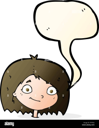

In [7]:
im = Image.open(dest)
im.to_thumb(128,128)

Ok, this is a great example of why going straight to image search is bad. The first image I got was [this](https://c8.alamy.com/comp/FTFFGG/cartoon-happy-female-face-with-speech-bubble-FTFFGG.jpg)

The image is a cartoon face with speech bubble. So maybe this blog post is "why you shouldn't use a naive image search for building models, but how to fight through the pain anyway."

Let's see if tweaking the search term helps...

https://thumbs.dreamstime.com/z/close-up-portrait-smiling-laughing-attractive-man-happy-face-human-emotion-expression-having-fun-joy-camera-152138665.jpg


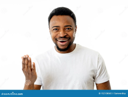

In [15]:
results = search_images_ddg('joyful human face photo')
ims = results
dest = 'images/test.jpg'
download_url(ims[20], dest)
print(ims[20])
im = Image.open(dest)
im.to_thumb(128,128)

Okay great, we definitely got a human [this time](https://thumbs.dreamstime.com/z/close-up-portrait-smiling-laughing-attractive-man-happy-face-human-emotion-expression-having-fun-joy-camera-152138665.jpg). Still though we can't see if ALL of our images are of humans, nor can we tell if we have a decent demographic distribution. Just highlighting the necessities of data curation and bias analysis. Technically it could be possible that this bias wouldn't impact the deployment. In my case, my goal is not to make a robust emotions classifier but to make a simple deployed proof of concept, so I'm pressing on 😁.

Speeding things up, we can add the classifications 'sad' and 'neutral' to our options.

In [16]:
#hide
searches = 'joyful', 'sad', 'neutral'
path = Path('human_emotion_images')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images_ddg(f'{o} human face photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)
print('Images downloaded!')

/home/aharon/.local/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/aharon/.local/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Images downloaded!


Another thing I noticed as I searched for face manually is that SO MANY of them are AI generated. Train a model of human emotion recognition on AI generated images of human faces does not seem like a good idea for any production level systems.


We'll go ahead and review our downloaded photos for any images that had errors during file trasnfer


In [17]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

18

# Training the Model (Round 1)

We have a dataset of emotions now! The dataset has not been curated though which can result in some issues as we discussed previously. Interestingly, I do not have the time to sort through 600 photos at this point. To aid me in my curation I will train the model first, and use the loss of each image to determine where some of the hiccups in data may be.

This method is detailed by Jeremy Howard in his book/course [Practical Deep Learning](https://course.fast.ai/).

But before we do any of that we'll need to create a training and a validation set from our data. We will use fastai's `DataLoader's` class.

In [18]:
faces = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
dls = faces.dataloaders(path)

A Quick Note. We use random resized crop to give us a little "extra" data here. It takes small sections of each photo and performs some standard image manipulation (data augmentation). This makes it seem like there's extra data to our model which needs all the help it can get. At this stage, we haven't curated our datset.

In [19]:
faces = faces.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = faces.dataloaders(path)

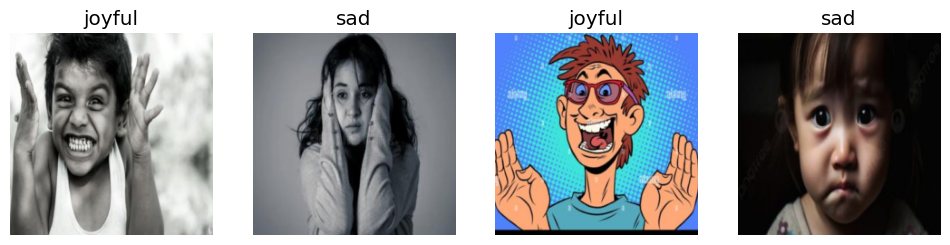

In [20]:
dls.valid.show_batch(max_n=4, nrows=1)

Now we have enough data to train the model. We'll see how the model performs.

In [21]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.867137,0.978214,0.422222,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.259917,0.820148,0.338889,00:02
1,1.092608,0.719830,0.294444,00:01
2,0.959672,0.695742,0.238889,00:02
3,0.855471,0.670721,0.244444,00:01


Ok the first training batch has it set so that the error rate is around 24.4%. Seems to be decent. It's much better than the starting rate of 42%.

We want to know if we can improve this error rate by curating the dataset.

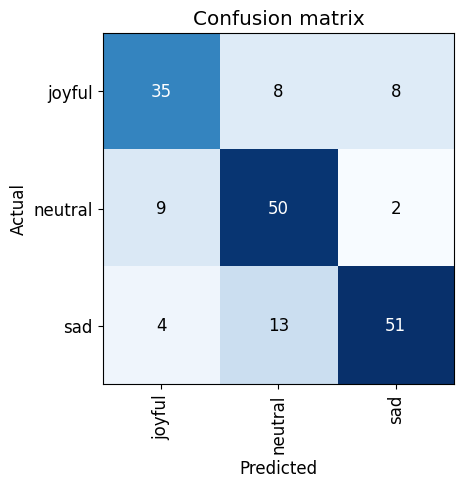

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

This confusion matrix helps determine where the errors are. Another way we can see where the errors are is using fastai's loss plotting tool:

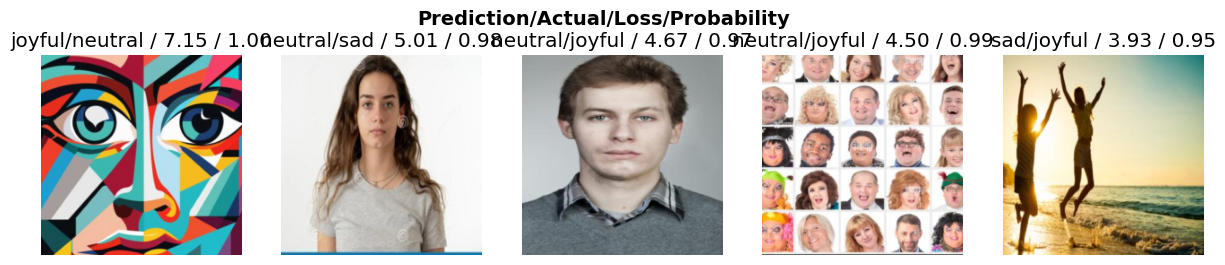

In [23]:
interp.plot_top_losses(5, nrows=1)

So using this loss plotting, we can already see where some of our issues are coming from:

* Some images classified as neutral are actually joyful
* Some images are cartoons or emojis
* Some images are multiple faces

Part of what I want to do here is explain some of the issues with data curation. I could go back and change my search terms to get rid of some of these issues, but this helps me show the issues with a naive search better.

Fortunately, fastai provides a tool for removing the high-loss images from the datasets.

In [24]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [30]:
# hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)


Reminder to self/anyone:

This code needs to be run for each combination of category/set-type. For example, if you go through the top losses in sad/valid, then you need to run this code, and move to sad/training.

## Local Environment Detour

Ok, its around here that I had to shift gears to set up my own local fastai and jupyter environment on my ML desktop. Long story short I built an ML workstation for this purpose. I needed to do this because I'm having trouble understanding how the cleaner modifies files and I can understand a local filesystem more clearly than google drive's (w/ colab).

Also, if you've ever tried to make a local ML environment than you'll know how PERSNICKITY this process can be (read: highly specific and thorny). So anyway, this is what I've been doing for the last day or so. Also, my latop broke and the first one I ordered to replace it DID NOT COME WITH A KEYBOARD 🙃

We soldier on...


Now I have edited the files in the original path. Some were moved and others were deleted. If I rebuild another dataloader from the original path it should be more accurate this time!

# Training the Model (Round 2)

In [39]:
faces = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
dls = faces.dataloaders(path)
faces = faces.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = faces.dataloaders(path)

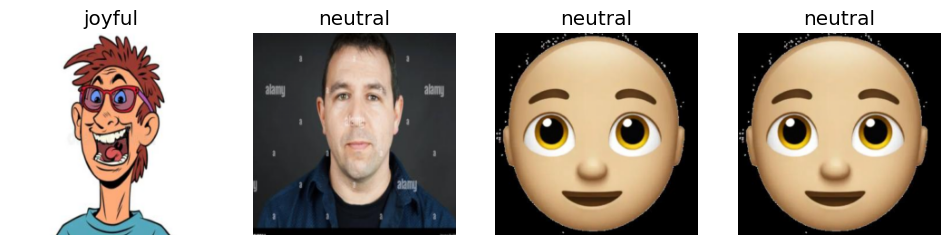

In [40]:
dls.valid.show_batch(max_n=4, nrows=1)

Why are there weird new images? These were always present in the dataset, and for some reason they did not propagate to the top of the cleaner. The cleaner only shows the hardest images for the model to classify (by their "loss" values). It's possible these images didn't have the highest loss values in their respective categories.

In [41]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.834946,1.177347,0.458824,00:01


epoch,train_loss,valid_loss,error_rate,time
0,1.159093,0.806116,0.341176,00:02
1,0.996075,0.596115,0.217647,00:01
2,0.841664,0.609325,0.194118,00:01
3,0.737599,0.586973,0.182353,00:01


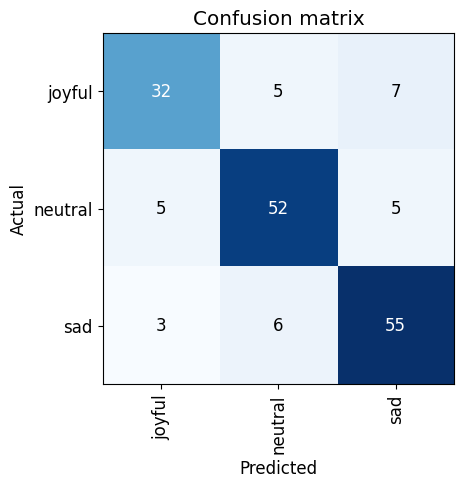

In [42]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Ok, so we can see that cleaning the data did actually improve the performance of the model. We can see the error rate decreased from 24.4% to 18.2%. Aditionally we can see that the confusion matrix is much more precise. There is only one square outside of the main diagonal that is slightly blue. So yes, this tool is effective and it helps us improve the model.


In [45]:
learn.export('model.pkl')

# Summary

So we trained a model on a dataset full of duckduckgo images that can generally determine the emotions of someone whose face it has a picture of. Kinda. 

We learned that creating a dataset is actually rather difficult, especially if its done primarily from internet image searches. 

However, we saw large success with the idea of training a model first, finding the circumstances that cause high loss values, and editign the dataset based on the images the model finds hardest to classify. In other words, training a model before the dataset is perfectly curated helps curate the dataset. This is incredibly useful.

There are also all sorts of issues when it comes to creating a dataset this way.

* Images that are animated or drawn
* AI generated images are starting to crop up and find their way into datasets
* There's all sorts of racial bias in the images that were returned

This is an effective proof of concept that suggests a facial emotion recognizer could work. You can check it out on [Hugging Face Spaces](https://huggingface.co/spaces/AaronJames95/emotion_classifier) here!

## Epilogue
Later I wanted to see if I could get better performance with the model if I got into all the images and modified them individually like in the cleaner. It took me roughly a half hour, and tI couldn't get it better than the second round of training. So, my assumption is that this problem (automating facial emotion ndetection) is simply non-trivial and there may be other ways to approach it. Also, determining the emotions of a face in a photo is highly subjective which could be another reason I'm not seeing better results.

I was really surprised by how much of an effective time save using the cleaner turned out to be! The first time I used it it took around 5 minutes and I got the same results as my 30 minutes image crawl of 600 pictures.
